In [4]:
from torch_geometric.datasets import MoleculeNet

In [5]:
data = MoleculeNet(root='.', name='ESOL')

In [6]:
data

ESOL(1128)

In [7]:
data[0]

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

info of dataset at: https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html

In [8]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)
print("Dataset sample2: ", data[1])
print("Sample2  nodes: ", data[1].num_nodes)
print("Sample2  edges: ", data[1].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68
Dataset sample2:  Data(x=[15, 9], edge_index=[2, 32], edge_attr=[32, 3], smiles='Cc1occc1C(=O)Nc2ccccc2', y=[1, 1])
Sample2  nodes:  15
Sample2  edges:  32


/Users/timii/miniconda3/envs/aienv/lib/python3.10/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


In [9]:
data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

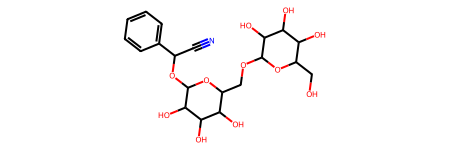

In [10]:
from rdkit import Chem

molecule = Chem.MolFromSmiles(data[0]['smiles'])
molecule

In [21]:
import os
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [25]:
class GCNModel(nn.Module):
    def __init__(self, features_dim, embedding_dim):
        self.features_dim = features_dim
        self.embedding_dim = embedding_dim
        super(GCNModel, self).__init__()
        self.initial_conv = GCNConv(self.features_dim, self.embedding_dim)
        self.conv1 = GCNConv(self.embedding_dim, self.embedding_dim)
        self.conv2 = GCNConv(self.embedding_dim, self.embedding_dim)
        self.conv3 = GCNConv(self.embedding_dim, self.embedding_dim)
        self.out = Linear(self.embedding_dim*2, 1)

    def forward(self, data):
        x, edge_index, batch = data.x.float(), data.edge_index, data.batch
        x = F.tanh(self.initial_conv(x, edge_index))
        x = F.tanh(self.conv1(x, edge_index))
        x = F.tanh(self.conv2(x, edge_index))
        x = F.tanh(self.conv3(x, edge_index))
        x = torch.cat([gap(x, batch), gmp(x, batch)], dim=1)
        out = self.out(x)
        return out, x
    
embedding_dim = 64  
model = GCNModel(data.num_features, embedding_dim)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCNModel(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [26]:
from torch_geometric.data import DataLoader

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
if torch.cuda.is_available():
    device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
else:
    device = torch.device('cpu')

model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding


print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 8.45584487915039


KeyboardInterrupt: 

<Axes: >

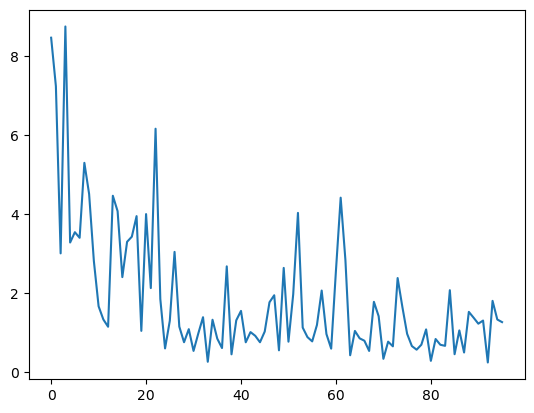

In [28]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(x=loss_indices, y=losses_float)
plt